### Physical Interpretation of Best Analytic Models

Taking only the PySR schemes from the Pareto frontier and their modified version that *always* satisfies the RH-constraint.

Actually, what we want to compute are the M-plots (https://christophm.github.io/interpretable-ml-book/ale.html#ale). They 'average the predictions over the conditional distribution'. What they do is 'Let me show you what the model predicts on average for data instances that have values close to v for that feature. The effect could be due to that feature, but also due to correlated features.'

Partial dependence plots assume that the features are uncorrelated. Let's say we are interested in f(T=290K).
Now f is a function of multiple variables f(T, RH, qi, qc). We then draw (RH, qi, qc) samples randomly from the dataset, compute f(T, RH, qi, qc) and average all predictions.
Even if this (RH, qi, qc) is completely unrealistic in combination with 290K.



In [1]:
# Ran with Python 3 environment
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import sympy as sp

sys.path.insert(0, os.environ['HOME'] + '/workspace_icon-ml/cloud_cover_parameterization')

import tensorflow as tf
import my_classes
import time
import json

from my_classes import read_mean_and_std
from tensorflow.keras.models import load_model
from tensorflow import nn

abspath = os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/evaluate_schemes/analyzing_eqns/'

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

matplotlib.use('PDF')

# Minimum amount of samples to accept a bin
# no_samples = 10000

no_samples = 10000

In [2]:
# Load data
base_path = '/home/b/b309170'
output_path = base_path + '/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND'

input_data = np.load(output_path + '/cloud_cover_input_dyamond.npy')
output_data = np.load(output_path + '/cloud_area_output_dyamond.npy')

# To locate variables
features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
                  'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']
len(features)

loc = {}
for i in range(len(features)):
    loc[features[i]] = i

In [3]:
# # Run with random subset (the entire dataset takes too much memory)
# np.random.seed(10)
# rand_int = np.random.randint(0, input_data.shape[0], 10**8)

# print(input_data.shape)
# input_data = input_data[rand_int]
# output_data = output_data[rand_int]

In [4]:
# Scale data
mean,std = read_mean_and_std(os.environ['HOME'] + '/workspace_icon-ml/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND/saved_models/cross_validation_neighborhood_based_sr_cl_area_fold_2.txt')

input_data_scaled = (input_data - mean)/std

all_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z', 'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_features)):
    loc_all[all_features[i]] = i

In [5]:
66106.8/2.03129

32544.24528255444

In [6]:
# Best PySR equations
with open(os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/optimized_eqns.json', 'r') as file:
    pysr_eqns = json.load(file)
    
rh, ta, rh_z, cli, clw = sp.symbols('rh ta rh_z cli clw')
x0, x1, x2, x3, x4 = sp.symbols('x0 x1 x2 x3 x4')
    
pysr_EQ1 = sp.lambdify((rh, ta, rh_z, cli, clw), pysr_eqns['EQ1']['Equation w.r.t. physical vars'])
# pysr_EQ4 = sp.lambdify((rh, ta, rh_z, cli, clw), pysr_eqns['EQ4']['Equation w.r.t. physical vars'])

def pysr_EQ1_mod(rh, ta, rh_z, cli, clw):
    # Artificially increase RH to ensure RH-constraint
    (a,b,c,d) = (38.85954116, 42.70818472, 19.34746465, 1.11321032)
    
    x0 = (rh - mean[loc_all['rh']])/std[loc_all['rh']]
    x1 = (ta - mean[loc_all['ta']])/std[loc_all['ta']]
    
    x0 = np.maximum(x0, 1/(2*c*d)*(-c*x1**2-a))
    
    rh = x0*std[loc_all['rh']] + mean[loc_all['rh']]
    
    return pysr_EQ1(rh, ta, rh_z, cli, clw)

def pysr_EQ4_mod(rh, ta, rh_z, cli, clw):
    # Based on pysr_eqns['EQ4']['Equation w.r.t. physical vars']
    # Slightly refined in symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/optimize_coefs_EQ4_check_physical_eqns.ipynb
    # i.e., removed one free parameter
    
    # (a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B) = (2.44602578e+02, 6.50754419e-02, 3.87865894e-02, 3.38579968e+01, 4.21678865e+03, 1.87848876e+01, 2.19807008e+03, 1.34231436e+05, 3.11805366e-03, 1.51425129e+00, 5.48080889e+00, 1.70666033e-06, 1.04823218e+00, 1.57514190e-04)
    (a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B) = (203, 0.06588, 0.03969, 33.87, 4224.6, 18.9586, 2202.6, 20000000000, 60000000, 8641, 32544, 0.0106, 1, 1)
    
    # Modified to always satisfy RH-constraint
    rh = np.maximum(rh, -a_2/(2*a_1)*ta**2 + a_4/(2*a_1)*ta - a_5/(2*a_1))
    
    I1 = a_1*rh**2+ta**2*(a_2*rh-a_3)-a_4*rh*ta+a_5*rh+a_6*ta-a_7
    I2 = (rh_z)**2*(a_8*rh_z+a_9) 
    I3 = -B/(a_10*clw+a_11*cli+eps)
    
    return I1 + I2 + I3

In [7]:
# Load NN
custom_objects = {}
custom_objects['leaky_relu'] = nn.leaky_relu

# SFS 24 (from workspace/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND/saved_models/cross_validation_neighborhood_based_sr_cl_area_fold_2.h5)
sfs_24_nn = load_model(os.environ['HOME'] + '/workspace_icon-ml/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND/saved_models/cross_validation_neighborhood_based_sr_cl_area_fold_2.h5', custom_objects)

def b(x):
    return np.minimum(np.maximum(x, 0), 100)

2023-04-03 13:46:43.128117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-03 13:46:43.130044: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-03 13:46:43.130755: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l40262.lvt.dkrz.de): /proc/driver/nvidia/version does not exist
2023-04-03 13:46:43.142150: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# ta_mean = np.mean(input_data[:, loc['ta']])
# rh_z_mean = np.mean(input_data[:, loc['rh_z']])
# cli_mean = np.mean(input_data[:, loc['cli']])
# clw_mean = np.mean(input_data[:, loc['clw']])
# rh_mean = np.mean(input_data[:, loc['rh']])

# ta_std = np.mean(input_data[:, loc['ta']])
# rh_z_std = np.mean(input_data[:, loc['rh_z']])
# cli_std = np.mean(input_data[:, loc['cli']])
# clw_std = np.mean(input_data[:, loc['clw']])
# rh_std = np.mean(input_data[:, loc['rh']])

**Relative Humidity**

In [9]:
t0 = time.time()

# Creating bins
no_bins = 50
rh_vals = np.linspace(np.min(input_data[:, loc['rh']]), np.max(input_data[:, loc['rh']]), no_bins)
digitized = np.digitize(input_data[:, loc['rh']], rh_vals)

# Indices of those bins with more than no_samples samples
inds_samples = [i for i in range(1, len(rh_vals) + 1) if np.sum(digitized == i) > no_samples]

# Data average
output_mean_data = [output_data[digitized == i].mean() for i in inds_samples]

# SFS NN 24
sfs_nn_24_pred = b(sfs_24_nn.predict_on_batch(input_data_scaled))
output_sfs_nn_24 = [np.mean(sfs_nn_24_pred[digitized == i]) for i in inds_samples]

# To be able to save the numbers
plot_values = {}
plot_values['RH values'] = list(rh_vals)
for eq_num in ['1', '1_mod', '4', '4_mod']:
    pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])
    pysr_output = b(locals()['pysr_EQ%s'%eq_num](*pysr_input_features))
    plot_values['pysr_EQ%s'%eq_num] = [pysr_output[digitized == i].mean() for i in inds_samples]
plot_values['sfs_nn_24'] = list(np.array(output_sfs_nn_24, dtype=np.float64))
plot_values['data_mean'] = list(np.array(output_mean_data, dtype=np.float64))
    
# Plot and save figure
# plt.plot(rh_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ1'], color=CB_color_cycle[3])
# plt.plot(rh_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ1_mod'], color=CB_color_cycle[4])
plt.plot(rh_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ4'], color=CB_color_cycle[0])
# plt.plot(rh_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ4_mod'], color=CB_color_cycle[1])
plt.plot(rh_vals[np.array(inds_samples) - 1], plot_values['sfs_nn_24'], color=CB_color_cycle[2])
plt.plot(rh_vals[np.array(inds_samples) - 1], plot_values['data_mean'], color='black')
plt.legend(['PySR equation', 'SFS NN 24', 'DYAMOND cl_area'])
plt.xlabel('Relative Humidity')
plt.ylabel('Cloud Cover')
# plt.savefig(os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/evaluate_schemes/analyzing_eqns/RH_vs_cl_area.pdf')

# Close figure
plt.close()
plt.clf()
plt.figure()

time.time() - t0

2023-04-03 12:59:34.036027: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 67.99GiB (rounded to 73005950464)requested by op sequential/dense/MatMul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-03 12:59:34.036098: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-04-03 12:59:34.036113: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 45, Chunks in use: 45. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 5.6KiB client-requested in use in bin.
2023-04-03 12:59:34.036122: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-04-03 12:59:34.036130: I

ResourceExhaustedError:  OOM when allocating tensor with shape[285179494,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/dense/MatMul
 (defined at /sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/layers/core/dense.py:199)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_402]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/dense/MatMul:
In[0] IteratorGetNext (defined at /sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/training.py:1610)	
In[1] sequential/dense/MatMul/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
>>>     app.start()
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 508, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 497, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 404, in dispatch_shell
>>>     await result
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 728, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
>>>     res = shell.run_cell(
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_2170425/3246887294.py", line 15, in <cell line: 15>
>>>     sfs_nn_24_pred = b(sfs_24_nn.predict_on_batch(input_data_scaled))
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/training.py", line 1986, in predict_on_batch
>>>     outputs = self.predict_function(iterator)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/keras/layers/core/dense.py", line 199, in call
>>>     outputs = tf.matmul(a=inputs, b=self.kernel)
>>> 

In [ ]:
with open(os.path.join(abspath, 'RH_plot_values.json'), 'w') as file:
    json.dump(plot_values, file)

**Temperature**

In [ ]:
t0 = time.time()

# Creating bins
no_bins = 50
ta_vals = np.linspace(np.min(input_data[:, loc['ta']]), np.max(input_data[:, loc['ta']]), no_bins)
digitized = np.digitize(input_data[:, loc['ta']], ta_vals)

# Indices of those bins with more than no_samples samples
inds_samples = [i for i in range(1, len(ta_vals) + 1) if np.sum(digitized == i) > no_samples]

# Data average
output_mean_data = [output_data[digitized == i].mean() for i in inds_samples]

# SFS NN 24
sfs_nn_24_pred = b(sfs_24_nn.predict_on_batch(input_data_scaled))
output_sfs_nn_24 = [np.mean(sfs_nn_24_pred[digitized == i]) for i in inds_samples]

# To be able to save the numbers
plot_values = {}
plot_values['T values'] = list(ta_vals)
for eq_num in ['1', '1_mod', '4', '4_mod']:
    pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])
    pysr_output = b(locals()['pysr_EQ%s'%eq_num](*pysr_input_features))
    plot_values['pysr_EQ%s'%eq_num] = [pysr_output[digitized == i].mean() for i in inds_samples]
plot_values['sfs_nn_24'] = list(np.array(output_sfs_nn_24, dtype=np.float64))
plot_values['data_mean'] = list(np.array(output_mean_data, dtype=np.float64))
    
# Plot and save figure
# plt.plot(ta_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ1'], color=CB_color_cycle[3])
# plt.plot(ta_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ1_mod'], color=CB_color_cycle[4])
plt.plot(ta_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ4'], color=CB_color_cycle[0])
# plt.plot(ta_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ4_mod'], color=CB_color_cycle[1])
plt.plot(ta_vals[np.array(inds_samples) - 1], plot_values['sfs_nn_24'], color=CB_color_cycle[2])
plt.plot(ta_vals[np.array(inds_samples) - 1], plot_values['data_mean'], color='black')
plt.legend(['PySR equation', 'SFS NN 24', 'DYAMOND cl_area'])
plt.xlabel('Temperature')
plt.ylabel('Cloud Cover')
# plt.savefig(os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/evaluate_schemes/analyzing_eqns/T_vs_cl_area.pdf')

# Close figure
plt.close()
plt.clf()
plt.figure()

time.time() - t0

In [ ]:
with open(os.path.join(abspath, 'T_plot_values.json'), 'w') as file:
    json.dump(plot_values, file)

**Relative Humidity and Temperature**

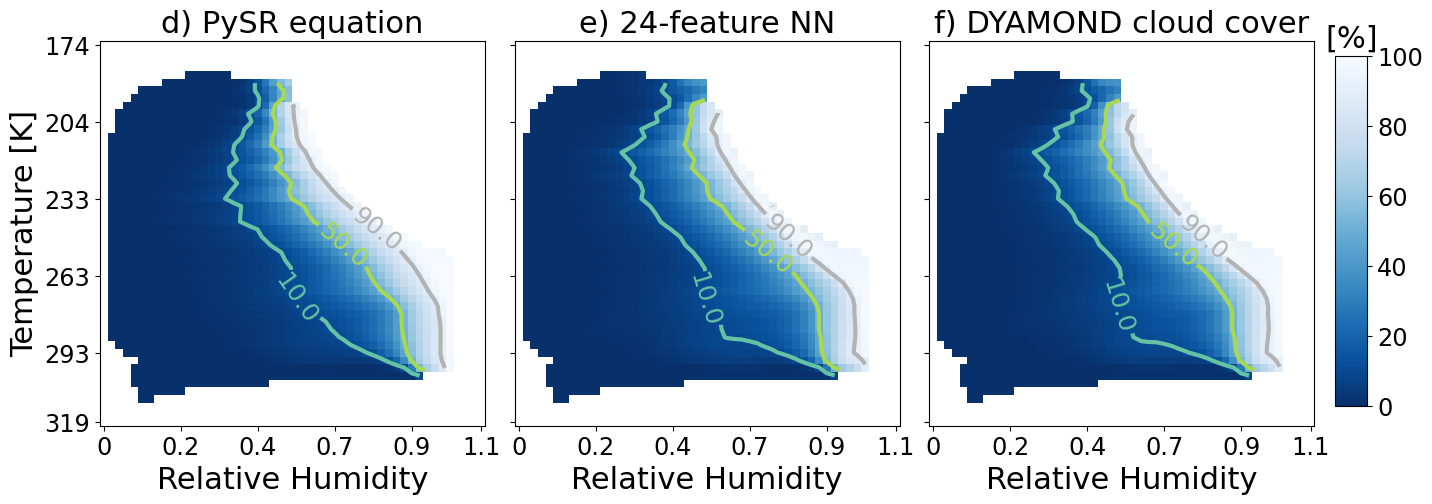

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [52]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# Increase the general font size
matplotlib.rcParams['legend.fontsize'] = 22
matplotlib.rcParams['axes.labelsize'] = 22 # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = 22
matplotlib.rcParams['xtick.labelsize'] = 17.28
matplotlib.rcParams['ytick.labelsize'] = 17.28

# Define the bounds
rh_min = np.min(input_data[:, loc['rh']])
rh_max = np.max(input_data[:, loc['rh']])
ta_min = np.min(input_data[:, loc['ta']])
ta_max = np.max(input_data[:, loc['ta']])

# Number of pixels in x- and y-direction
N_x = 50
N_y = 50

# Creating bins
rh_vals = np.linspace(rh_min, 1.1, N_x)
ta_vals = np.linspace(ta_min, ta_max, N_y)
digitized_rh = np.digitize(input_data[:, loc['rh']], rh_vals)
digitized_ta = np.digitize(input_data[:, loc['ta']], ta_vals)

# Creating mesh 
x = np.linspace(rh_min, 1.1, N_x)
y = np.linspace(ta_min, ta_max, N_y)
X,Y = meshgrid(x, y)

# Features relevant for the pysr equations
pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])

# Predictions
no_models = 2
# pred_pysr_eq1 = b(locals()['pysr_EQ1'](*pysr_input_features))
# pred_pysr_eq1_mod = b(locals()['pysr_EQ1_mod'](*pysr_input_features))
# pred_pysr_eq4 = b(locals()['pysr_EQ4'](*pysr_input_features))
pred_pysr_eq4_mod = b(locals()['pysr_EQ4_mod'](*pysr_input_features))
pred_sfs_24_nn = b(sfs_24_nn.predict_on_batch(input_data_scaled))[:, 0]

# Compute conditional averages
plot_titles = ['d) PySR equation', 'e) 24-feature NN', 'f) DYAMOND cloud cover']
Z = {key: np.zeros((N_x, N_y)) for key in plot_titles}
for M in range(N_x):
    for N in range(N_y):
        bin_inds = np.where((digitized_rh == M) & (digitized_ta == N))[0]
        if len(bin_inds) > no_samples:
            Z['f) DYAMOND cloud cover'][M, N] = np.mean(output_data[bin_inds])
            # Z['pysr_EQ1'][M, N] = np.mean(pred_pysr_eq1[bin_inds])
            # Z['pysr_EQ1_mod'][M, N] = np.mean(pred_pysr_eq1_mod[bin_inds])
            # Z['pysr_EQ4'][M, N] = np.mean(pred_pysr_eq4[bin_inds])
            Z['d) PySR equation'][M, N] = np.mean(pred_pysr_eq4_mod[bin_inds])
            Z['e) 24-feature NN'][M, N] = np.mean(pred_sfs_24_nn[bin_inds])
        else:
            for key in Z.keys():
                Z[key][M, N] = None
                
# It looks like we have to transpose the output here
for key in Z.keys():
    Z[key] = Z[key].T

# Setting up the figure
fig = plt.figure(figsize=(16, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.01)

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):
    # Add new subplot iteratively
    if i == 0:
        ax = plt.subplot(1, 3, i + 1, xticks=[0,10,20,30,40,49], yticks=[0,10,20,30,40,49])
        ax.set_yticklabels(['%d'%val for val in [y[0],y[10],y[20],y[30],y[40],y[49]]])
    if i != 0:
        ax = plt.subplot(1, 3, i + 1, xticks=[0,10,20,30,40,49], yticks=[0,10,20,30,40,49])
        # Remove tick labels for the other subplots
        ax.set_yticklabels([' ',' ',' ',' ',' ',' '])
        
    ## Replace tick labels by proper tick labels. It's a bit cumbersome with imshow.    
    ax.set_xticklabels(['0'] + ['%.1f'%val for val in [x[10],x[20],x[30],x[40],x[49]]])
    axis = axes[:i] + axes[(i+1):]
                
    title(title_name)
    im = ax.imshow(Z[title_name], vmin=0, vmax=100, cmap='Blues_r')

    # Adding the Contour lines with labels
    cset = ax.contour(Z[title_name], np.arange(10,100,40),linewidths=3,cmap=cm.Set2)
    ax.clabel(cset,inline=True,fmt='%1.1f',fontsize=18)
    # latex fashion title
    plt.xlabel('Relative Humidity')
    if i == 0:
        plt.ylabel('Temperature [K]')
        # colorbar(im) # adding the colorbar on the right
    # show()
    
cbar_ax = fig.add_axes([0.905, 0.15, 0.02, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('[%]')

plt.savefig('rh_and_T_vs_cl_area_new.pdf', bbox_inches='tight')
    
plt.show()

# Restore default figsize
plt.close()
plt.clf()
plt.figure()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

**Cloud Ice**

In [30]:
t0 = time.time()

# Creating bins
no_bins = 50
cli_vals = np.linspace(np.min(input_data[:, loc['cli']]), np.max(input_data[:, loc['cli']]), no_bins)
digitized = np.digitize(input_data[:, loc['cli']], cli_vals)

# Indices of those bins with more than no_samples samples
inds_samples = [i for i in range(1, len(cli_vals) + 1) if np.sum(digitized == i) > no_samples]

# Data average
output_mean_data = [output_data[digitized == i].mean() for i in inds_samples]

# SFS NN 24
sfs_nn_24_pred = b(sfs_24_nn.predict_on_batch(input_data_scaled))
output_sfs_nn_24 = [np.mean(sfs_nn_24_pred[digitized == i]) for i in inds_samples]

# To be able to save the numbers
plot_values = {}
plot_values['qi values'] = list(cli_vals)
for eq_num in ['1', '1_mod', '4', '4_mod']:
    pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])
    pysr_output = b(locals()['pysr_EQ%s'%eq_num](*pysr_input_features))
    plot_values['pysr_EQ%s'%eq_num] = [pysr_output[digitized == i].mean() for i in inds_samples]
plot_values['sfs_nn_24'] = list(np.array(output_sfs_nn_24, dtype=np.float64))
plot_values['data_mean'] = list(np.array(output_mean_data, dtype=np.float64))
    
# Plot and save figure
# plt.plot(cli_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ1'], color=CB_color_cycle[3])
# plt.plot(cli_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ1_mod'], color=CB_color_cycle[4])
plt.plot(cli_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ4'], color=CB_color_cycle[0])
# plt.plot(cli_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ4_mod'], color=CB_color_cycle[1])
plt.plot(cli_vals[np.array(inds_samples) - 1], plot_values['sfs_nn_24'], color=CB_color_cycle[2])
plt.plot(cli_vals[np.array(inds_samples) - 1], plot_values['data_mean'], color='black')
plt.legend(['PySR equation', 'SFS NN 24', 'DYAMOND cl_area'])
plt.xlabel('Cloud Ice [kg/kg]')
plt.ylabel('Cloud Cover')
# plt.savefig(os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/evaluate_schemes/analyzing_eqns/qi_vs_cl_area.pdf')

# Close figure
plt.close()
plt.clf()
plt.figure()

time.time() - t0

180.8457546234131

In [31]:
with open(os.path.join(abspath, 'qi_plot_values.json'), 'w') as file:
    json.dump(plot_values, file)

**Cloud Water**

In [32]:
t0 = time.time()

# Creating bins
no_bins = 50
clw_vals = np.linspace(np.min(input_data[:, loc['clw']]), np.max(input_data[:, loc['clw']]), no_bins)
digitized = np.digitize(input_data[:, loc['clw']], clw_vals)

# Indices of those bins with more than no_samples samples
inds_samples = [i for i in range(1, len(clw_vals) + 1) if np.sum(digitized == i) > no_samples]

# Data average
output_mean_data = [output_data[digitized == i].mean() for i in inds_samples]

# SFS NN 24
sfs_nn_24_pred = b(sfs_24_nn.predict_on_batch(input_data_scaled))
output_sfs_nn_24 = [np.mean(sfs_nn_24_pred[digitized == i]) for i in inds_samples]

# To be able to save the numbers
plot_values = {}
plot_values['qc values'] = list(clw_vals)
for eq_num in ['1', '1_mod', '4', '4_mod']:
    pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])
    pysr_output = b(locals()['pysr_EQ%s'%eq_num](*pysr_input_features))
    plot_values['pysr_EQ%s'%eq_num] = [pysr_output[digitized == i].mean() for i in inds_samples]
plot_values['sfs_nn_24'] = list(np.array(output_sfs_nn_24, dtype=np.float64))
plot_values['data_mean'] = list(np.array(output_mean_data, dtype=np.float64))
    
# Plot and save figure
# plt.plot(clw_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ1'], color=CB_color_cycle[3])
# plt.plot(clw_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ1_mod'], color=CB_color_cycle[4])
plt.plot(clw_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ4'], color=CB_color_cycle[0])
# plt.plot(clw_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ4_mod'], color=CB_color_cycle[1])
plt.plot(clw_vals[np.array(inds_samples) - 1], plot_values['sfs_nn_24'], color=CB_color_cycle[2])
plt.plot(clw_vals[np.array(inds_samples) - 1], plot_values['data_mean'], color='black')
plt.legend(['PySR equation', 'SFS NN 24', 'DYAMOND cl_area'])
plt.xlabel('Cloud Water [kg/kg]')
plt.ylabel('Cloud Cover')
# plt.savefig(os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/evaluate_schemes/analyzing_eqns/qc_vs_cl_area.pdf')

# Close figure
plt.close()
plt.clf()
plt.figure()

time.time() - t0

196.67689657211304

In [33]:
with open(os.path.join(abspath, 'qc_plot_values.json'), 'w') as file:
    json.dump(plot_values, file)

**Cloud Water and Ice**

In [34]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# Increase the general font size
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large' # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = 'x-large'
matplotlib.rcParams['xtick.labelsize'] = 'xx-large'
matplotlib.rcParams['ytick.labelsize'] = 'xx-large'

# Define the bounds
clw_min = np.min(input_data[:, loc['clw']])
clw_max = np.max(input_data[:, loc['clw']])
cli_min = np.min(input_data[:, loc['cli']])
cli_max = np.max(input_data[:, loc['cli']])

# Number of pixels in x- and y-direction
N_x = 50
N_y = 50

# Creating bins
clw_vals = np.linspace(clw_min, clw_max/20, N_x)
cli_vals = np.linspace(cli_min, cli_max/20, N_y)
digitized_clw = np.digitize(input_data[:, loc['clw']], clw_vals)
digitized_cli = np.digitize(input_data[:, loc['cli']], cli_vals)

# Creating mesh 
x = np.linspace(clw_min, clw_max/20, N_x)
y = np.linspace(cli_min, cli_max/20, N_y)
X,Y = meshgrid(x, y)

# Features relevant for the pysr equations
pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])

# Predictions
no_models = 2
# pred_pysr_eq1 = b(locals()['pysr_EQ1'](*pysr_input_features))
# pred_pysr_eq1_mod = b(locals()['pysr_EQ1_mod'](*pysr_input_features))
# pred_pysr_eq4 = b(locals()['pysr_EQ4'](*pysr_input_features))
pred_pysr_eq4_mod = b(locals()['pysr_EQ4_mod'](*pysr_input_features))
pred_sfs_24_nn = b(sfs_24_nn.predict_on_batch(input_data_scaled))[:, 0]

# Compute conditional averages
plot_titles = ['PySR equation', 'SFS NN, 24 features', 'DYAMOND cloud area fraction']
Z = {key: np.zeros((N_x, N_y)) for key in plot_titles}
for M in range(N_x):
    for N in range(N_y):
        bin_inds = np.where((digitized_clw == M) & (digitized_cli == N))[0]
        if len(bin_inds) > no_samples:
            Z['DYAMOND cloud area fraction'][M, N] = np.mean(output_data[bin_inds])
            # Z['pysr_EQ1'][M, N] = np.mean(pred_pysr_eq1[bin_inds])
            # Z['pysr_EQ1_mod'][M, N] = np.mean(pred_pysr_eq1_mod[bin_inds])
            # Z['pysr_EQ4'][M, N] = np.mean(pred_pysr_eq4[bin_inds])
            Z['PySR equation'][M, N] = np.mean(pred_pysr_eq4_mod[bin_inds])
            Z['SFS NN, 24 features'][M, N] = np.mean(pred_sfs_24_nn[bin_inds])
        else:
            for key in Z.keys():
                Z[key][M, N] = None
                
# It looks like we have to transpose the output here
for key in Z.keys():
    Z[key] = Z[key].T

# Setting up the figure
fig = plt.figure(figsize=(18, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.01)

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):
    # Add new subplot iteratively
    if i == 0:
        ax = plt.subplot(1, 3, i + 1, xticks=[0,10,20,30,40,49], yticks=[0,10,20,30,40,49])
        ax.set_yticklabels(['%.0e'%val for val in [y[0],y[10],y[20],y[30],y[40],y[49]]])
    if i != 0:
        ax = plt.subplot(1, 3, i + 1, xticks=[0,10,20,30,40,49], yticks=[0,10,20,30,40,49])
        # Remove tick labels for the other subplots
        ax.set_yticklabels([' ',' ',' ',' ',' ',' '])
        
    ## Replace tick labels by proper tick labels. It's a bit cumbersome with imshow.    
    ax.set_xticklabels(['%.0e'%val for val in [x[0],x[10],x[20],x[30],x[40],x[49]]])
    axis = axes[:i] + axes[(i+1):]
                
    title(title_name)
    im = ax.imshow(Z[title_name], vmin=0, vmax=100, cmap='Blues_r')

    # Adding the Contour lines with labels
    cset = ax.contour(Z[title_name], np.arange(10,100,40),linewidths=3,cmap=cm.Set2)
    ax.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    # latex fashion title
    plt.xlabel('Cloud Water [kg/kg]')
    if i == 0:
        plt.ylabel('Cloud Ice [kg/kg]')
        # colorbar(im) # adding the colorbar on the right
    # show()
    
cbar_ax = fig.add_axes([0.905, 0.15, 0.02, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('[%]')

# plt.savefig(os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/evaluate_schemes/analyzing_eqns/clw_and_cli_vs_cl_area.pdf',
#            bbox_inches='tight')

# Restore default figsize
plt.close()
plt.clf()
plt.figure()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

**RH_z**

In [39]:
# Increase the general font size
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 20 # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = 22
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

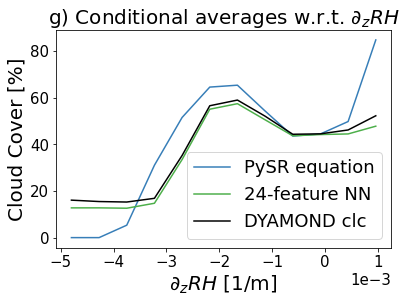

1006.9655730724335

In [41]:
t0 = time.time()

# Creating bins
no_bins = 50
rh_z_vals = np.linspace(np.min(input_data[:, loc['rh_z']]), np.max(input_data[:, loc['rh_z']]), no_bins)
digitized = np.digitize(input_data[:, loc['rh_z']], rh_z_vals)

# Indices of those bins with more than no_samples samples
inds_samples = [i for i in range(1, len(rh_z_vals) + 1) if np.sum(digitized == i) > no_samples]

# Data average
output_mean_data = [output_data[digitized == i].mean() for i in inds_samples]

# SFS NN 24
sfs_nn_24_pred = b(sfs_24_nn.predict_on_batch(input_data_scaled))
output_sfs_nn_24 = [np.mean(sfs_nn_24_pred[digitized == i]) for i in inds_samples]

# To be able to save the numbers
plot_values = {}
plot_values['rh_z values'] = list(rh_z_vals)
for eq_num in ['1', '1_mod', '4_mod']:
    pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])
    pysr_output = b(locals()['pysr_EQ%s'%eq_num](*pysr_input_features))
    plot_values['pysr_EQ%s'%eq_num] = [pysr_output[digitized == i].mean() for i in inds_samples]
plot_values['sfs_nn_24'] = list(np.array(output_sfs_nn_24, dtype=np.float64))
plot_values['data_mean'] = list(np.array(output_mean_data, dtype=np.float64))
    
# Plot and save figure
# plt.plot(rh_z_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ1'], color=CB_color_cycle[3])
# plt.plot(rh_z_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ1_mod'], color=CB_color_cycle[4])
# plt.plot(rh_z_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ4'], color=CB_color_cycle[1])
plt.plot(rh_z_vals[np.array(inds_samples) - 1], plot_values['pysr_EQ4_mod'], color=CB_color_cycle[0])
plt.plot(rh_z_vals[np.array(inds_samples) - 1], plot_values['sfs_nn_24'], color=CB_color_cycle[2])
plt.plot(rh_z_vals[np.array(inds_samples) - 1], plot_values['data_mean'], color='black')
plt.ticklabel_format(axis='x', style='sci', scilimits=(-2,0))
plt.legend(['PySR equation', '24-feature NN', 'DYAMOND clc'])
plt.xlabel('$\partial_zRH$ [1/m]')
plt.ylabel('Cloud Cover [%]')
plt.title('g) Conditional averages w.r.t. $\partial_zRH$')
plt.savefig('rh_z_vs_cl_area_new.pdf', bbox_inches='tight')

# Close figure
plt.close()
plt.clf()
plt.figure()

# plt.show()

time.time() - t0

In [38]:
with open(os.path.join(abspath, 'rh_z_plot_values.json'), 'w') as file:
    json.dump(plot_values, file)

**Investigate continuity (PC7) of the equation**

In [28]:
# Read the data
pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])

# Set all cloud condensates to zero
pysr_input_features[-2:] = 0
pysr_output = b(locals()['pysr_EQ4_mod'](*pysr_input_features))

# 15% of samples violate continuity if cli = clw = 0
print(np.sum(pysr_output > 1e-8)/len(pysr_output))

0.15277279719137168


Which characteristics do the samples have that yield positive clc without cloud condensates?

- RH is relatively large <br>
- rh_z, T are comparable

(array([3.7227526e+07, 1.8622159e+07, 1.4343509e+07, 1.2532747e+07,
        1.2369497e+07, 1.7035106e+07, 2.1581944e+07, 2.3589980e+07,
        3.1632243e+07, 6.8899156e+07, 2.7319112e+07, 2.3205000e+04,
        3.0850000e+03, 1.1700000e+02, 5.8000000e+01, 2.4000000e+01,
        8.0000000e+00, 1.1000000e+01, 6.0000000e+00, 1.0000000e+00]),
 array([4.19415359e-04, 9.60039193e-02, 1.91588423e-01, 2.87172927e-01,
        3.82757431e-01, 4.78341935e-01, 5.73926439e-01, 6.69510943e-01,
        7.65095447e-01, 8.60679951e-01, 9.56264455e-01, 1.05184896e+00,
        1.14743346e+00, 1.24301797e+00, 1.33860247e+00, 1.43418697e+00,
        1.52977148e+00, 1.62535598e+00, 1.72094049e+00, 1.81652499e+00,
        1.91210949e+00]),
 <BarContainer object of 20 artists>)

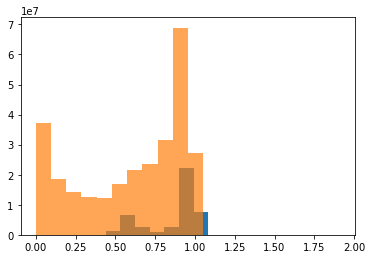

In [36]:
# RH
plt.hist(pysr_input_features[0, pysr_output > 1e-8], bins=20)
plt.hist(pysr_input_features[0, :], bins=20, alpha=.7)

(array([1.8878000e+04, 4.6032500e+05, 3.3686110e+06, 9.8441430e+06,
        1.4149669e+07, 1.4637937e+07, 1.7350288e+07, 1.3771690e+07,
        1.1724287e+07, 1.4096094e+07, 1.6665383e+07, 1.8308938e+07,
        2.3008674e+07, 2.9389843e+07, 2.9015865e+07, 3.3850358e+07,
        3.0797895e+07, 4.4855830e+06, 2.2607800e+05, 8.9550000e+03]),
 array([174.30621338, 181.58222504, 188.85823669, 196.13424835,
        203.41026001, 210.68627167, 217.96228333, 225.23829498,
        232.51430664, 239.7903183 , 247.06632996, 254.34234161,
        261.61835327, 268.89436493, 276.17037659, 283.44638824,
        290.7223999 , 297.99841156, 305.27442322, 312.55043488,
        319.82644653]),
 <BarContainer object of 20 artists>)

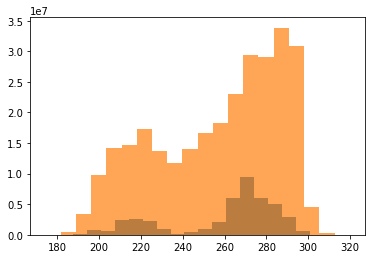

In [37]:
# T
plt.hist(pysr_input_features[1, pysr_output > 1e-8], bins=20)
plt.hist(pysr_input_features[1, :], bins=20, alpha=.7)

(-0.002, 0.002)

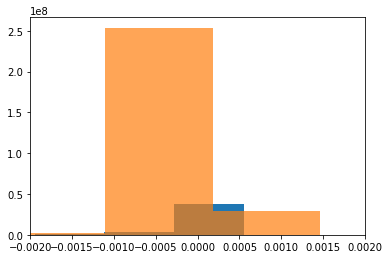

In [42]:
# rh_z
plt.hist(pysr_input_features[2, pysr_output > 1e-8], bins=20)
plt.hist(pysr_input_features[2, :], bins=20, alpha=.7)
plt.xlim([-0.002, 0.002])

How many samples violate continuity if I remove all samples with RH > thr?

In [50]:
# Read the data
pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])

# Set all cloud condensates to zero
pysr_input_features[-2:] = 0
pysr_output = b(locals()['pysr_EQ4_mod'](*pysr_input_features))

# Only consider samples where RH is small
rh_small = (pysr_input_features[0] <= 0.6)

# 5% of samples violate continuity if cli = clw = 0 and RH is small
print(np.sum(pysr_output[rh_small] > 1e-8)/len(pysr_output[rh_small]))

0.051693341573897274


Maybe we should look at the condensate-free samples and see which of those would yield a positive cloud cover!

In [15]:
# Read the data
pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])
cond_free = pysr_input_features[-2] + pysr_input_features[-1] < 1e-12

# Predict cloud cover for all condensate-free samples
pysr_output = b(locals()['pysr_EQ4_mod'](*pysr_input_features[:, cond_free]))

# 15% of samples violate continuity if cli = clw = 0
print(np.sum(pysr_output > 1e-8)/len(pysr_output))

0.00352430668700831


In [17]:
# Read the data
pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])
cond_free = pysr_input_features[-2] + pysr_input_features[-1] < 1e-12

# Predict cloud cover for all condensate-free samples
pysr_output = b(locals()['pysr_EQ4_mod'](*pysr_input_features[:, cond_free]))

# Only consider samples where RH is small
rh_small = (pysr_input_features[0, cond_free] <= 0.6)

# 5% of samples violate continuity if cli = clw = 0 and RH is small
print(np.sum(pysr_output[rh_small] > 1e-8)/len(pysr_output[rh_small]))

0.00125295235633012


In [18]:
# Read the data
pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])
cond_free = pysr_input_features[-2] + pysr_input_features[-1] < 1e-12

# Predict cloud cover for all condensate-free samples
pysr_output = b(locals()['pysr_EQ4_mod'](*pysr_input_features[:, cond_free]))

# Only consider samples where RH is small
rh_small = (pysr_input_features[0, cond_free] <= 0.7)

# 5% of samples violate continuity if cli = clw = 0 and RH is small
print(np.sum(pysr_output[rh_small] > 1e-8)/len(pysr_output[rh_small]))

0.0015633229278342869


In [19]:
# Read the data
pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])
cond_free = pysr_input_features[-2] + pysr_input_features[-1] < 1e-12

# Predict cloud cover for all condensate-free samples
pysr_output = b(locals()['pysr_EQ4_mod'](*pysr_input_features[:, cond_free]))

# Only consider samples where RH is small
rh_small = (pysr_input_features[0, cond_free] <= 0.8)

# 5% of samples violate continuity if cli = clw = 0 and RH is small
print(np.sum(pysr_output[rh_small] > 1e-8)/len(pysr_output[rh_small]))

0.001937042394777252


### Investigate why/when we need the RH_z term

We investigate why we need I2 altogether --> For a summary see #275

In [111]:
# Read the data
pysr_input_features = np.array([input_data[:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])

# Not predicting condensate-free samples.
cond_samples = pysr_input_features[:, pysr_input_features[-2] + pysr_input_features[-1] > 1e-12]

# All predictions. 
pysr_output = b(locals()['pysr_EQ4_mod'](*cond_samples))

# Ablation test: Set I2/rh_z to zero.
cond_samples_no_I2 = cond_samples.copy()
cond_samples_no_I2[2] = 0
pysr_output_no_I2 = b(locals()['pysr_EQ4_mod'](*cond_samples_no_I2))

# Relative error
err_rel = np.abs((pysr_output_no_I2 - pysr_output)/(pysr_output + 1e-4))
# Absolute error
err_abs = np.abs(pysr_output_no_I2 - pysr_output)

Bin averages in terms of absolute error

Text(0.5, 1.0, 'clc')

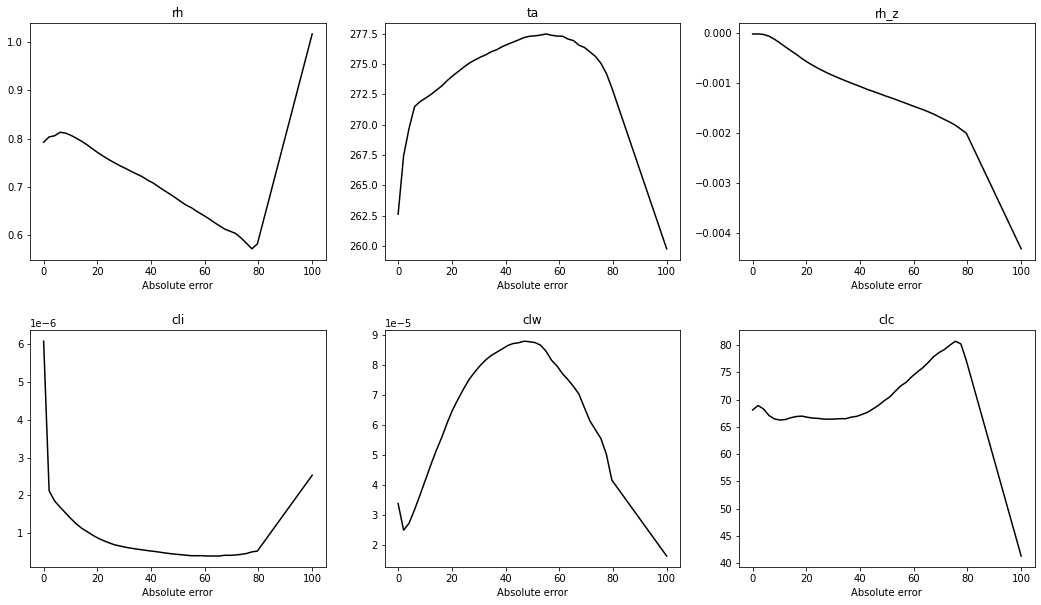

In [132]:
no_bins = 50
err_abs_bins = np.linspace(np.min(err_abs), np.max(err_abs), no_bins)
digitized = np.digitize(err_abs, err_abs_bins)

# Setting up the figure
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plot_titles = ['rh', 'ta', 'rh_z', 'cli', 'clw']

# Indices of those bins with more than no_samples samples
inds_samples = [j for j in range(1, len(err_abs_bins) + 1) if np.sum(digitized == j) > no_samples]

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):

    # Data average
    averages = [cond_samples[i, digitized == j].mean() for j in inds_samples]

    ax = plt.subplot(2, 3, i + 1)
    ax.plot(err_abs_bins[np.array(inds_samples) - 1], list(np.array(averages, dtype=np.float64)), color='black')
    plt.xlabel('Absolute error')
    plt.title(plot_titles[i])
    
# Data average
averages = [output_data[pysr_input_features[-2] + pysr_input_features[-1] > 1e-12][digitized == j].mean() for j in inds_samples]

ax = plt.subplot(2, 3, 6)
ax.plot(err_abs_bins[np.array(inds_samples) - 1], list(np.array(averages, dtype=np.float64)), color='black')
plt.xlabel('Absolute error')
plt.title('clc')

**Careful, values with absolute error above 80 are not super reliable:**

In [161]:
for j in range(1, 51):
    print(np.sum(digitized == j))

148201024
14218391
7012693
4039530
2614220
1835950
1368662
1076442
873394
720033
608980
523958
456846
400658
354791
315426
283882
254321
230777
209587
190780
175454
162950
149558
138235
127608
116921
106100
96856
87887
80502
73272
66321
59412
51515
45014
40333
36355
36507
16795
858
780
782
772
728
771
708
672
751
18921


In [162]:
# Only 0.01% of the data
20000/148201024

0.00013495183407099805

In terms of other interesting variables

In [120]:
# Variables we could investigate
loc

{'hus': 0,
 'clw': 1,
 'cli': 2,
 'ta': 3,
 'pa': 4,
 'zg': 5,
 'fr_land': 6,
 'U': 7,
 'rh': 8,
 'ps': 9,
 'hus_z': 10,
 'hus_zz': 11,
 'clw_z': 12,
 'clw_zz': 13,
 'cli_z': 14,
 'cli_zz': 15,
 'ta_z': 16,
 'ta_zz': 17,
 'pa_z': 18,
 'pa_zz': 19,
 'U_z': 20,
 'U_zz': 21,
 'rh_z': 22,
 'rh_zz': 23}

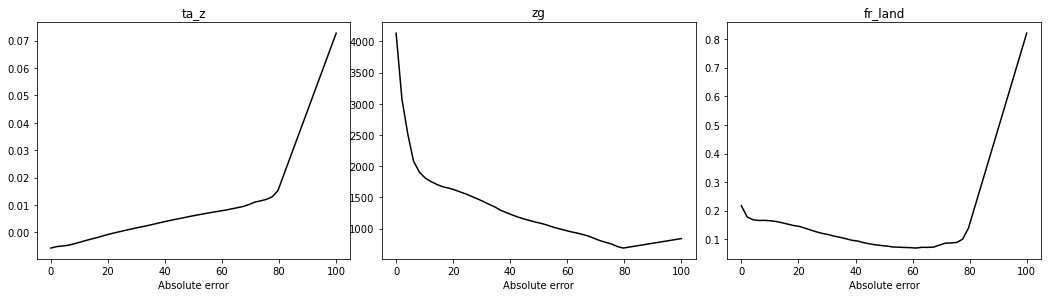

In [164]:
no_bins = 50
err_abs_bins = np.linspace(np.min(err_abs), np.max(err_abs), no_bins)
digitized = np.digitize(err_abs, err_abs_bins)

# Setting up the figure
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plot_titles = ['ta_z', 'zg', 'fr_land']

cond_free_input_data = (input_data[input_data[:, loc['cli']] + input_data[:, loc['clw']] > 1e-12]).T

# Indices of those bins with more than no_samples samples
inds_samples = [j for j in range(1, len(err_abs_bins) + 1) if np.sum(digitized == j) > no_samples]

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):

    # Data average
    averages = [cond_free_input_data[loc[title_name], digitized == j].mean() for j in inds_samples]

    ax = plt.subplot(2, 3, i + 1)
    ax.plot(err_abs_bins[np.array(inds_samples) - 1], list(np.array(averages, dtype=np.float64)), color='black')
    plt.xlabel('Absolute error')
    plt.title(title_name)

Average error in terms of cloud regimes (absolute and relative I2 error)

In [86]:
cod_subs = input_data[:, loc['cli']] + input_data[:, loc['clw']]

# Set to be the same as in evaluate_schemes/on_isccp_regimes
cod_subs_med = 1.62e-5 
pa_med = 78787

input_data_reg_1 = input_data[(1e-12 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc['pa']] < pa_med)]
input_data_reg_2 = input_data[(1e-12 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc['pa']] > pa_med)]
input_data_reg_3 = input_data[(cod_subs > cod_subs_med) & (input_data[:, loc['pa']] < pa_med)]
input_data_reg_4 = input_data[(cod_subs > cod_subs_med) & (input_data[:, loc['pa']] > pa_med)]

In [92]:
for ind in range(1, 5):
    # Read the data
    pysr_input_features = np.array([globals()['input_data_reg_%d'%ind][:,loc[feat]] for feat in ['rh', 'ta', 'rh_z', 'cli', 'clw']])

    # Not predicting condensate-free samples.
    cond_samples = pysr_input_features[:, pysr_input_features[-2] + pysr_input_features[-1] > 1e-12]

    # All predictions. 
    pysr_output = b(locals()['pysr_EQ4_mod'](*cond_samples))

    # Ablation test: Set I2/rh_z to zero.
    cond_samples[2] = 0
    pysr_output_no_I2 = b(locals()['pysr_EQ4_mod'](*cond_samples))

    # Relative error
    locals()['err_rel_%d'%ind] = np.abs((pysr_output_no_I2 - pysr_output)/(pysr_output + 1e-4))
    # Absolute error
    locals()['err_abs_%d'%ind] = np.abs(pysr_output_no_I2 - pysr_output)

Text(0, 0.5, 'Average absolute error')

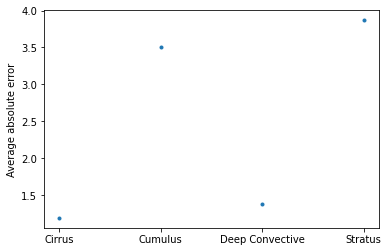

In [104]:
X_reg = ['Cirrus', 'Cumulus', 'Deep Convective', 'Stratus']
plt.plot(X_reg, [err_abs_1.mean(), err_abs_2.mean(), err_abs_3.mean(), err_abs_4.mean()], '.')
plt.ylabel('Average absolute error')

Text(0, 0.5, 'Average relative error')

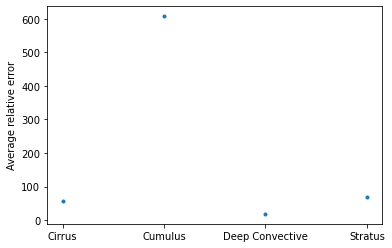

In [105]:
plt.plot(X_reg, [err_rel_1.mean(), err_rel_2.mean(), err_rel_3.mean(), err_rel_4.mean()], '.')
plt.ylabel('Average relative error')

For the cumulus regime

Text(0.5, 1.0, 'clc')

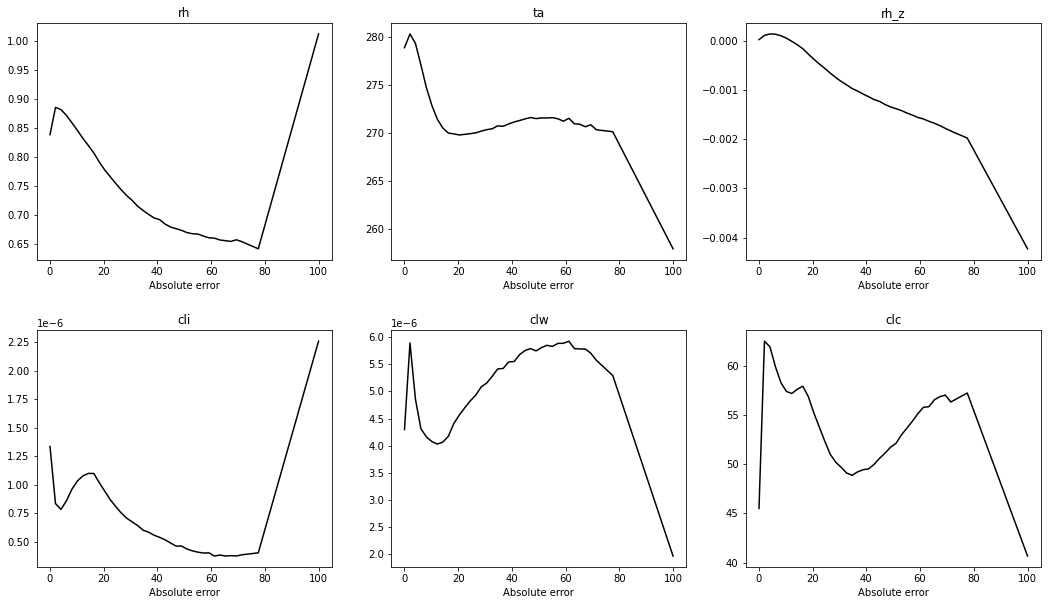

In [126]:
no_bins = 50
err_abs_2_bins = np.linspace(np.min(err_abs_2), np.max(err_abs_2), no_bins)
digitized = np.digitize(err_abs_2, err_abs_2_bins)

# Setting up the figure
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Indices of those bins with more than no_samples samples
inds_samples = [j for j in range(1, len(err_abs_2_bins) + 1) if np.sum(digitized == j) > no_samples]

plot_titles = ['rh', 'ta', 'rh_z', 'cli', 'clw']

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):

    # Data average
    averages = [input_data_reg_2.T[loc[plot_titles[i]], digitized == j].mean() for j in inds_samples]

    ax = plt.subplot(2, 3, i + 1)
    ax.plot(err_abs_2_bins[np.array(inds_samples) - 1], list(np.array(averages, dtype=np.float64)), color='black')
    plt.xlabel('Absolute error')
    plt.title(plot_titles[i])
    
# Data average
averages = [output_data_reg_2.T[digitized == j].mean() for j in inds_samples]

ax = plt.subplot(2, 3, 6)
ax.plot(err_abs_2_bins[np.array(inds_samples) - 1], list(np.array(averages, dtype=np.float64)), color='black')
plt.xlabel('Absolute error')
plt.title('clc')

For the stratus regime

Text(0.5, 1.0, 'clc')

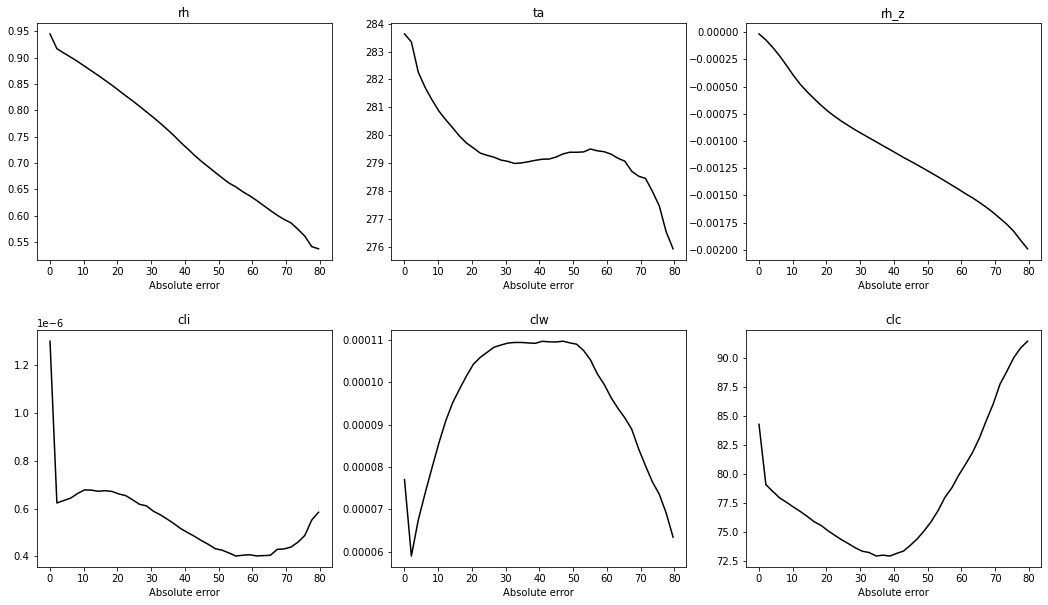

In [127]:
no_bins = 50
err_abs_4_bins = np.linspace(np.min(err_abs_4), np.max(err_abs_4), no_bins)
digitized = np.digitize(err_abs_4, err_abs_4_bins)

# Setting up the figure
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plot_titles = ['rh', 'ta', 'rh_z', 'cli', 'clw']

# Indices of those bins with more than no_samples samples
inds_samples = [j for j in range(1, len(err_abs_4_bins) + 1) if np.sum(digitized == j) > no_samples]

axes = tuple(np.arange(len(plot_titles)))
for i, title_name in enumerate(plot_titles):

    # Data average
    averages = [input_data_reg_4.T[loc[plot_titles[i]], digitized == j].mean() for j in inds_samples]

    ax = plt.subplot(2, 3, i + 1)
    ax.plot(err_abs_4_bins[np.array(inds_samples) - 1], list(np.array(averages, dtype=np.float64)), color='black')
    plt.xlabel('Absolute error')
    plt.title(plot_titles[i])
    
# Data average
averages = [output_data_reg_4.T[digitized == j].mean() for j in inds_samples]

ax = plt.subplot(2, 3, 6)
ax.plot(err_abs_4_bins[np.array(inds_samples) - 1], list(np.array(averages, dtype=np.float64)), color='black')
plt.xlabel('Absolute error')
plt.title('clc')